## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_error
from xgboost import XGBRegressor
import pickle
from utils import Scatter_Violin_Plots, Performance_metrics, Hbar
from sklearn.inspection import permutation_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Import datasets

In [2]:
# Import the training dataset
train = pd.read_excel("./Datasets/Output/BDA/df_Train_BDA_confined.xlsx")

# Import the testing dataset
test = pd.read_excel("./Datasets/Output/BDA/df_Test_BDA_confined.xlsx")

In [3]:
# Spliting the dependent (y) variable and independent (X) variables for training dataset
ID_train = train[['ZC5']]
y_train = train[['mean_BDA']]
X_train = train[['mean_BPV', 'mean_WD', 
       'SBu_build_', 'Pri_Res_P', 'Thr_M_FL_P', 'Ele_buil_P',
       'w_base_P', 'One_FL_P', 'Two_FL_P', 
       'PCT_Dvl','PCT_Frs', 'PCT_Wtr',
       'max_acc7', 'average_non_zero',
       'Mean_Slope', 'Mean_TWI',  'Mean_SPI',
        'svi']] 

# Spliting the dependent (y) variable and independent (X) variables for testing dataset 
ID_test = test[['ZC5']]
y_test = test[['mean_BDA']]
X_test = test[['mean_BPV', 'mean_WD', 
       'SBu_build_', 'Pri_Res_P', 'Thr_M_FL_P', 'Ele_buil_P',
       'w_base_P', 'One_FL_P', 'Two_FL_P', 
       'PCT_Dvl','PCT_Frs', 'PCT_Wtr',
       'max_acc7', 'average_non_zero',
       'Mean_Slope', 'Mean_TWI',  'Mean_SPI',
        'svi']] 

## Model Development

In [4]:
# Define the range of XGBR hyperparameters
space={
    'max_depth': hp.quniform("max_depth", 2, 10, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.6, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 2, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200])
    }

In [5]:
def objective(space):
    model=XGBRegressor(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        n_estimators = space['n_estimators'],
        colsample_bytree = space['colsample_bytree'],
        min_child_weight = space['min_child_weight']
    )

    model.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

    pred = model.predict(X_test.to_numpy())
    accuracy = r2_score(y_test, pred)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [6]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

100%|██████████| 200/200 [00:13<00:00, 15.35trial/s, best loss: -0.75498446400821]  


In [7]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8832853429650944, 'learning_rate': 0.12361595458644943, 'max_depth': 5.0, 'min_child_weight': 2.0, 'n_estimators': 1}


In [8]:
xgb = XGBRegressor(colsample_bytree = 0.8, 
                   learning_rate = 0.05,
                    max_depth = 6,
                    min_child_weight = 2,
                    n_estimators = 100,
                    random_state=42
)

In [9]:
xgb.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Export Developed Model 

In [10]:
# Export and save the final trained model 
with open('./XGBR/Best_Param/xgbr_BDA_value_Best_model', "wb") as fp:
    pickle.dump(xgb, fp)

In [11]:
# Import the final trained model 
with open('./XGBR/Best_Param/xgbr_BDA_value_Best_model', "rb") as fp:
    xgb= pickle.load(fp)

## Apply the Best Model to Predict

In [12]:
# Make prediction on testing dataset using final trained model
xgbr_pred_test = xgb.predict(X_test)
xgbr_pred_train = xgb.predict(X_train)

## Performance Metrics

In [13]:
Metrics = pd.DataFrame()
Model_names = [ 'Train', 'Test']
pred_list = [xgbr_pred_train, xgbr_pred_test]
obs_list = [ y_train, y_test]

for i in range(0,len(pred_list)):
    X = obs_list[i]
    Y = pred_list[i]
    df = pd.DataFrame({f'{Model_names[i]}': [ Performance_metrics(X, Y, "Yes")[0], Performance_metrics(X, Y, "Yes")[1], Performance_metrics(X, Y, "Yes")[2], Performance_metrics(X, Y, "Yes")[3], Performance_metrics(X, Y, "Yes")[4]]})
    Metrics= pd.concat([df, Metrics], axis=1)

Metrics = Metrics.rename( index={  0:'R\N{SUPERSCRIPT TWO}', 1:'NSE', 2:'KGE', 3:'APB (%)',  4:'RMSE ($)'})
Metrics.style

,Test,Train
R²,0.742,0.998
NSE,0.736,0.997
KGE,0.751,0.966
APB (%),1.586,0.092
RMSE ($),21037.271,2573.042


## Visualisation 

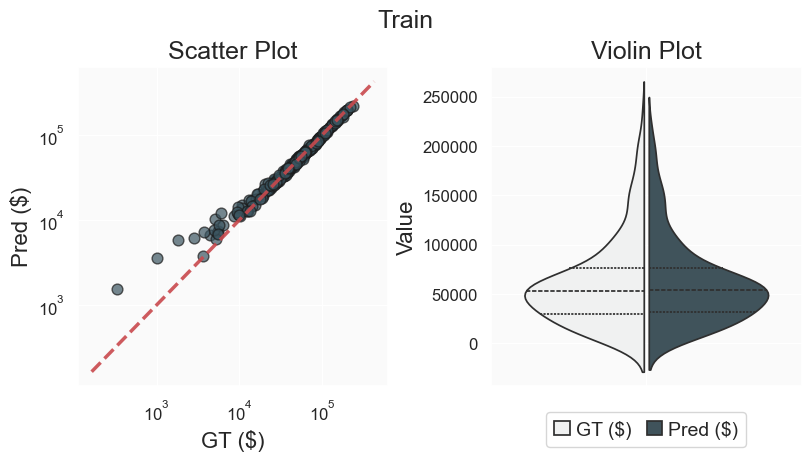

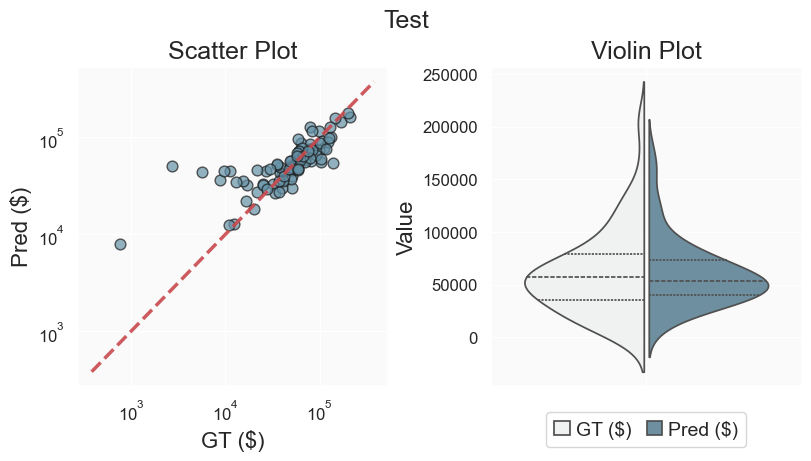

In [14]:
Title = ['Train', 'Test']
fc = ['#3B5560', '#6592A7']
pred_list = [xgbr_pred_train, xgbr_pred_test]
obs_list = [y_train,  y_test]

for i in range(0,len(pred_list)):
    X = obs_list[i]
    Y = pred_list[i]
    Scatter_Violin_Plots(X, Y, "GT ($)", "Pred ($)", "Value", Title[i], fc[i])

## Feature Importance Analaysis

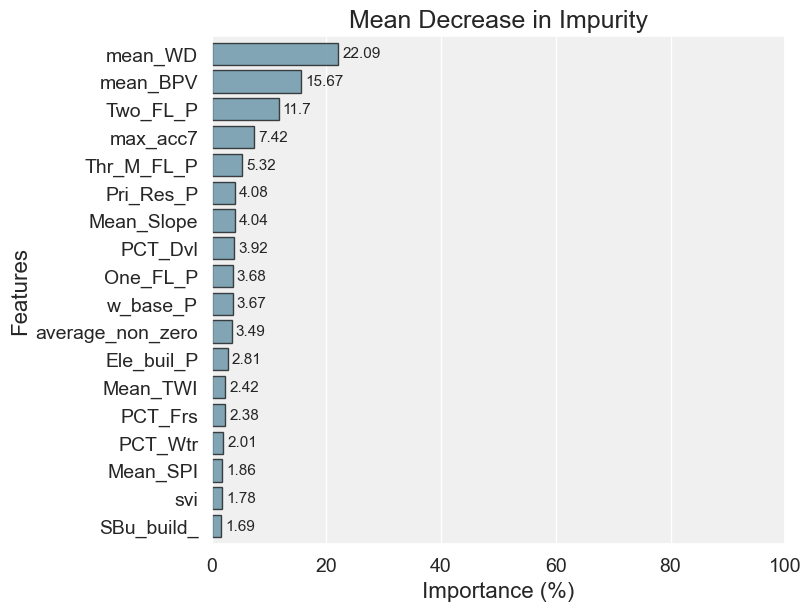

In [15]:
# MDI analysis
result_train = permutation_importance(xgb, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
importances_train = xgb.feature_importances_
xgbr_importances_MDI_train = pd.Series(importances_train, index=X_train.columns)
xgbr_importances_MDI_train.sort_values(ascending=True, inplace=True)
xgbr_importances_MDI_train = xgbr_importances_MDI_train.multiply(100)
xgbr_importances_MDI_train = xgbr_importances_MDI_train.round( decimals=2)

# Visualization of results
Hbar(xgbr_importances_MDI_train, 'Mean Decrease in Impurity', '#6592A7')